<a href="https://colab.research.google.com/github/ldsAS/Tibame-AI-Learning/blob/main/Tibame_LAB_HR%E8%AA%B2%E5%A0%82%E7%B7%B4%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 人員資料 預測離職 分類問題

In [1]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../content/R公司_人員資料_train.csv')
data.head()

,員工編號(EmployeeNumber),性別(Gender),年齡(Age),是否為成年人(Over18),婚姻狀態(MaritalStatus),通勤距離(DistanceFromHome),教育程度(Education),教育專業領域(EducationField),部門(Department),職位名稱(JobRole),...,股票選擇權等級(StockOptionLevel),績效評估(PerformanceRating),出差頻率(BusinessTravel),去年訓練時間(TrainingTimesLastYear),工作滿意度(JobSatisfaction),工作環境滿意度(EnvironmentSatisfaction),工作投入(JobInvolvement),工作生活平衡(WorkLifeBalance),人際關係滿意度(RelationshipSatisfaction),離職(Attrition)
0,1551,Male,24,Y,Divorced,21,2,Technical Degree,Research & Development,Laboratory Technician,...,3,3,Travel_Rarely,3,1,3,2,3,2,No
1,1012,Male,18,Y,Single,5,2,Life Sciences,Research & Development,Research Scientist,...,0,3,Non-Travel,2,4,2,3,3,4,No
2,349,Male,29,Y,Divorced,20,2,Marketing,Sales,Sales Executive,...,1,3,Travel_Rarely,2,4,4,3,3,4,No
3,1654,Male,39,Y,Married,12,3,Medical,Research & Development,Manufacturing Director,...,0,4,Travel_Rarely,3,2,4,3,3,3,No
4,1881,Male,31,Y,Divorced,20,3,Life Sciences,Research & Development,Laboratory Technician,...,1,3,Travel_Rarely,2,3,2,3,3,1,No


In [2]:
#列出欄位名稱
data.columns

Index(['員工編號(EmployeeNumber)', '性別(Gender)', '年齡(Age)', '是否為成年人(Over18)',
       '婚姻狀態(MaritalStatus)', '通勤距離(DistanceFromHome)', '教育程度(Education)',
       '教育專業領域(EducationField)', '部門(Department)', '職位名稱(JobRole)',
       '職位等級(JobLevel)', '在該公司工作總年資(YearsAtCompany)',
       '在該職位工作年資(YearsInCurrentRole)', '在該職等工作年資(YearsSinceLastPromotion)',
       '與現任管理者工作年資(YearsWithCurrManager)', '總工作年資(TotalWorkingYears)',
       '過去工作公司家數(NumCompaniesWorked)', '每日工資額(DailyRate)',
       '每小時工資額(HourlyRate)', '月收入(MonthlyIncome)', '月費率(MonthlyRate)',
       '標準工作時間(StandardHours)', '加班(OverTime)', '調薪百分比(PercentSalaryHike)',
       '股票選擇權等級(StockOptionLevel)', '績效評估(PerformanceRating)',
       '出差頻率(BusinessTravel)', '去年訓練時間(TrainingTimesLastYear)',
       '工作滿意度(JobSatisfaction)', '工作環境滿意度(EnvironmentSatisfaction)',
       '工作投入(JobInvolvement)', '工作生活平衡(WorkLifeBalance)',
       '人際關係滿意度(RelationshipSatisfaction)', '離職(Attrition)'],
      dtype='object')

In [10]:
data.shape

(1176, 34)

In [4]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['離職(Attrition)'])

In [5]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- 自動前處理類別 (AutoPreprocess Class) ---
# 這是我們在汽車價格預測專案中建立的同一個類別，可以直接重複使用。
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            # 自動補空值
            if data[fname].dtype == object or data[fname].dtype == str:
                self.fillna_value[fname] = data[fname].mode()[0]
            elif data[fname].dtype == bool:
                self.fillna_value[fname] = data[fname].mode()[0]
            else:
                self.fillna_value[fname] = data[fname].median()

            # 自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str):
                pass
            elif data[fname].dtype == bool:
                pass
            else:
                if data[fname].isin([0, 1]).all():
                    pass
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10:
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else:
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])

            # 自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str):
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = f"{fname}_{value}"
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool:
                self.final_field_names.append(fname)
            else:
                self.final_field_names.append(fname)

    def transform(self, data):
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else:
            data = data.copy()

        for fname in self.field_names:
            if data[fname].isnull().any():
                data[fname] = data[fname].fillna(self.fillna_value[fname])

            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            if (data[fname].dtype == object) or (data[fname].dtype == str):
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                    for value in field_value:
                        fn = f"{fname}_{value}"
                        data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool:
                data[fname] = data[fname].astype(int)
            else:
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

# 載入訓練資料
data = pd.read_csv('R公司_人員資料_train.csv')
print("資料載入成功，前五筆記錄：")
data.head()

資料載入成功，前五筆記錄：


,員工編號(EmployeeNumber),性別(Gender),年齡(Age),是否為成年人(Over18),婚姻狀態(MaritalStatus),通勤距離(DistanceFromHome),教育程度(Education),教育專業領域(EducationField),部門(Department),職位名稱(JobRole),...,股票選擇權等級(StockOptionLevel),績效評估(PerformanceRating),出差頻率(BusinessTravel),去年訓練時間(TrainingTimesLastYear),工作滿意度(JobSatisfaction),工作環境滿意度(EnvironmentSatisfaction),工作投入(JobInvolvement),工作生活平衡(WorkLifeBalance),人際關係滿意度(RelationshipSatisfaction),離職(Attrition)
0,1551,Male,24,Y,Divorced,21,2,Technical Degree,Research & Development,Laboratory Technician,...,3,3,Travel_Rarely,3,1,3,2,3,2,No
1,1012,Male,18,Y,Single,5,2,Life Sciences,Research & Development,Research Scientist,...,0,3,Non-Travel,2,4,2,3,3,4,No
2,349,Male,29,Y,Divorced,20,2,Marketing,Sales,Sales Executive,...,1,3,Travel_Rarely,2,4,4,3,3,4,No
3,1654,Male,39,Y,Married,12,3,Medical,Research & Development,Manufacturing Director,...,0,4,Travel_Rarely,3,2,4,3,3,3,No
4,1881,Male,31,Y,Divorced,20,3,Life Sciences,Research & Development,Laboratory Technician,...,1,3,Travel_Rarely,2,3,2,3,3,1,No


In [7]:
# 1. 初始化前處理物件
ap = AutoPreprocess()

# 2. 定義要進行前處理的特徵欄位
# 我們將 'Attrition' (目標) 和 'EmployeeNumber' (員工編號，通常不具預測性) 排除
feature_columns = data.columns.drop(['離職(Attrition)', '員工編號(EmployeeNumber)'])

# 3. 學習如何處理這些特徵欄位
print("開始學習資料前處理規則...")
ap.fit(data, field_names=feature_columns)
print("學習完成！")

# 4. 儲存學好的前處理模型以供未來使用
ap.save("HR_preprocess.bin")
print("前處理模型已儲存為 HR_preprocess.bin")

# 5. 轉換特徵資料
X = ap.transform(data)
print("\n特徵資料轉換完成，轉換後的前五筆記錄：")
print(X.head())


# 6. 處理目標欄位 (y)
# 將 'Yes' 轉為 1, 'No' 轉為 0
y = data['離職(Attrition)'].map({'Yes': 1, 'No': 0})
print("\n目標欄位 '離職(Attrition)' 轉換完成。")

開始學習資料前處理規則...
學習完成！
前處理模型已儲存為 HR_preprocess.bin

特徵資料轉換完成，轉換後的前五筆記錄：
   性別(Gender)_Male  性別(Gender)_Female   年齡(Age)  是否為成年人(Over18)_Y  \
0                1                  0 -1.388559                 1   
1                1                  0 -2.040738                 1   
2                1                  0 -0.845077                 1   
3                1                  0  0.241886                 1   
4                1                  0 -0.627685                 1   

   婚姻狀態(MaritalStatus)_Married  婚姻狀態(MaritalStatus)_Single  \
0                            0                           0   
1                            0                           1   
2                            0                           0   
3                            1                           0   
4                            0                           0   

   婚姻狀態(MaritalStatus)_Divorced  通勤距離(DistanceFromHome)  教育程度(Education)  \
0                             1                1.440396           

In [8]:
# 1. 分割資料為訓練組與驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"資料已分割，訓練集大小: {X_train.shape[0]}，驗證集大小: {X_valid.shape[0]}")

# 2. 初始化並訓練模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
print("\n開始訓練隨機森林模型...")
model.fit(X_train, y_train)
print("模型訓練完成！")

# 3. 在驗證組上進行預測並評估準確率
y_pred = model.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)

print(f"\n模型在驗證組上的準確率 (Accuracy): {acc:.4f}")

# 4. 儲存訓練好的模型
with open("HR_model.bin", "wb") as f:
    pickle.dump(model, f)
print("機器學習模型已儲存為 HR_model.bin")

資料已分割，訓練集大小: 940，驗證集大小: 236

開始訓練隨機森林模型...
模型訓練完成！

模型在驗證組上的準確率 (Accuracy): 0.8475
機器學習模型已儲存為 HR_model.bin


模型在驗證組上的準確率 (Accuracy): 0.8475

詳細分類報告 (Classification Report):
              precision    recall  f1-score   support

     留任 (No)       0.84      0.99      0.91       191
    離職 (Yes)       0.91      0.22      0.36        45

    accuracy                           0.85       236
   macro avg       0.88      0.61      0.64       236
weighted avg       0.86      0.85      0.81       236


混淆矩陣 (Confusion Matrix):


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30041 (\N{CJK UNIFIED IDEOGRAPH-7559}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20219 (\N{CJK UNIFIED IDEOGRAPH-4EFB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32887 (\N{CJK UNIFIED IDEOGRAPH-8077}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas

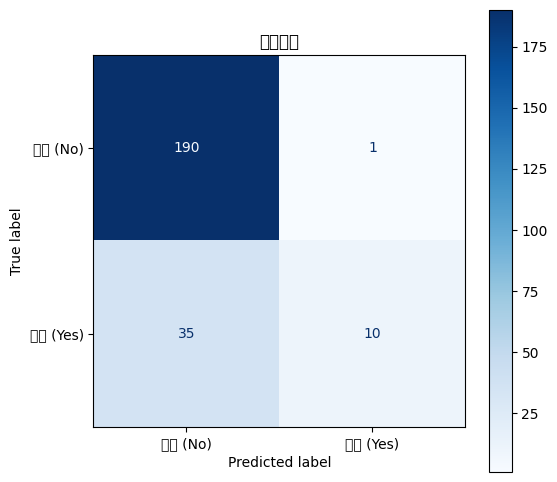

In [12]:
# 載入需要的驗證工具與繪圖函式庫
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- 在「驗證組」上進行預測 ---
# 使用訓練好的模型，對它沒見過的驗證資料進行預測
y_pred = model.predict(X_valid)


# --- 1. 計算評估指標 (Metrics) ---
# 計算準確率
acc = accuracy_score(y_valid, y_pred)
print(f"模型在驗證組上的準確率 (Accuracy): {acc:.4f}\n")

# 顯示更詳細的分類報告 (包含精確率 Precision、召回率 Recall、F1-score)
print("詳細分類報告 (Classification Report):")
# target_names 可以讓我們為 0 和 1 兩類設定標籤
print(classification_report(y_valid, y_pred, target_names=['留任 (No)', '離職 (Yes)']))


# --- 2. 繪製混淆矩陣 (Confusion Matrix) ---
print("\n混淆矩陣 (Confusion Matrix):")
# 建立一個畫布
fig, ax = plt.subplots(figsize=(6, 6))

# 使用 ConfusionMatrixDisplay.from_estimator 快速繪製混淆矩陣
ConfusionMatrixDisplay.from_estimator(
    model,
    X_valid,
    y_valid,
    ax=ax,
    display_labels=['留任 (No)', '離職 (Yes)'], # 在圖表上顯示標籤
    cmap=plt.cm.Blues  # 使用藍色系的配色
)
plt.title('混淆矩陣')
plt.show()